# 📧 AI-Powered Email Classifier – Deep Learning Project

##Welcome to the **AI-Powered Email Classifier**!  
###This notebook presents a complete end-to-end solution to automatically detect and classify emails into three categories:

- ✅ **Ham** – Legitimate emails
- ⚠️ **Spam** – Unwanted promotional or bulk content
- 🚨 **Phishing** – Deceptive emails that attempt to steal sensitive information

---

### 🔍 Project Highlights:
- 🧠 Built using **Deep Learning (CNN)** and **Traditional Machine Learning (Random Forest & SVM)**
- 📊 Evaluates and compares model performance using precision, recall, F1-score, and confusion matrices
- 🌐 Real-time predictions through an interactive **Streamlit web interface**
- 🔤 Cleaned and processed using **NLTK**, **TF-IDF**, and modern text preprocessing techniques
- 💡 Includes model reasoning to explain each prediction

---

### 🛠️ Tools & Libraries Used:
- Python 🐍 | TensorFlow | Scikit-learn | Gensim | Pandas | Streamlit | Pyngrok



# 📦 Import Python Libraries

In [5]:
# Standard libraries
import os
import re
import email
import mailbox
import joblib

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import ConfusionMatrixDisplay

# NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

# Sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# ♻️ Enable Auto-Reload for Modules

In [6]:
%load_ext autoreload
%autoreload 2

# 💾 Mount Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
#Change path to "DL/Datasets" for large datasets
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "DL/Reduced_Datasets"
assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', 'DL', 'Reduced_Datasets')
print(os.listdir(GOOGLE_DRIVE_PATH))

['spam.csv', 'phishing.csv', 'ham.csv', 'phishing.gsheet', 'spam.gsheet']


# 📁 Load Email Datasets (Phishing, Spam, Ham)


In [9]:
# Load all three CSVs
phishing_df = pd.read_csv(os.path.join('/content', GOOGLE_DRIVE_PATH, 'phishing.csv'), encoding='latin1')
spam_df = pd.read_csv(os.path.join('/content', GOOGLE_DRIVE_PATH, 'spam.csv'), encoding='latin1')
ham_df = pd.read_csv(os.path.join('/content', GOOGLE_DRIVE_PATH, 'ham.csv'), encoding='latin1')

# 🧹 Preprocess Email Content (HTML removal, cleaning)

In [10]:
# Select relevant columns and normalize to "text" and "label"
phishing_df = phishing_df[['body']].dropna()
phishing_df = phishing_df.rename(columns={'body': 'text'})
phishing_df['label'] = 2  # 2 = phishing

spam_df = spam_df[['text']].dropna()
spam_df['label'] = 1  # 1 = spam

# Convert 'Ham'/'Spam' to 0/1
ham_df = ham_df[['label', 'text']].dropna()
ham_df['label'] = ham_df['label'].map({'Ham': 0, 'Spam': 1})

# 🔗 Combine Ham, Spam, and Phishing Into a Unified Dataset

In [11]:
# Combine everything into one DataFrame
combined_df = pd.concat([phishing_df, spam_df, ham_df], ignore_index=True)

# Shuffle the dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Drop rows with missing labels or text
combined_df = combined_df.dropna(subset=['text', 'label'])

# Convert float labels to int
combined_df['label'] = combined_df['label'].astype(int)

print(combined_df['label'].value_counts())
print(combined_df.head())

label
1    1195
0     219
2     169
Name: count, dtype: int64
                                                text  label
0  the meeting scheduled for escapenumber escapen...      0
2  Subject: your order # 5056  shopping for a loa...      1
4  Subject: make a fortune on ebay 24772  ebay - ...      1
5  Subject: fw : keep it under wraps , but this o...      1
7  Subject: your logo and visual identity from us...      1


In [12]:
# Artificially boost phishing samples to improve class balance
#(NOT NEEDED IF USING LARGE DATASETS)
phishing_df = combined_df[combined_df['label'] == 2]
boosted_phishing = pd.concat([phishing_df] * 5, ignore_index=True)  # 3x boost
df_balanced = pd.concat([combined_df[combined_df['label'] != 2], boosted_phishing], ignore_index=True)
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

# Update the working DataFrame
combined_df = df_balanced

# 🔄 Text Preprocessing Pipeline

In [13]:
STOPWORDS = set(stopwords.words("english"))

def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower().split()
    return " ".join([word for word in text if word not in STOPWORDS])

# Apply to all emails
processed_texts = combined_df['text'].apply(preprocess_text)
labels = combined_df['label'].tolist()

# 🧠 Convert Text to Vectors Using TF-IDF

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(processed_texts)
y = labels

# ✂️ Train-Test Split for Random Forest & SVM

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Train and Evaluate Random Forest Model

Random Forest Report:
               precision    recall  f1-score   support

           0       0.97      0.68      0.80        50
           1       0.94      0.98      0.96       240
           2       0.97      1.00      0.98       162

    accuracy                           0.96       452
   macro avg       0.96      0.89      0.92       452
weighted avg       0.96      0.96      0.95       452



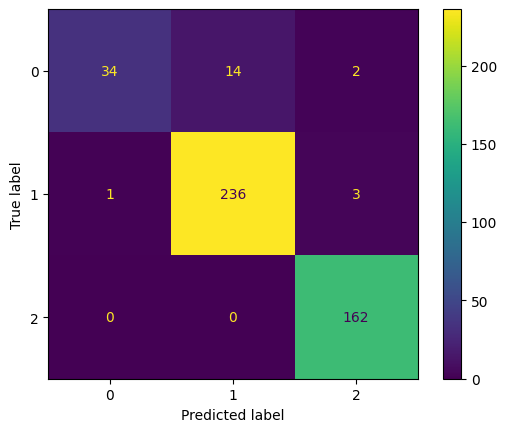

In [16]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot()

# 🧮 Train and Evaluate SVM Model

SVM Report:
               precision    recall  f1-score   support

           0       0.81      0.70      0.75        50
           1       0.94      0.96      0.95       240
           2       0.99      1.00      1.00       162

    accuracy                           0.95       452
   macro avg       0.92      0.89      0.90       452
weighted avg       0.94      0.95      0.95       452



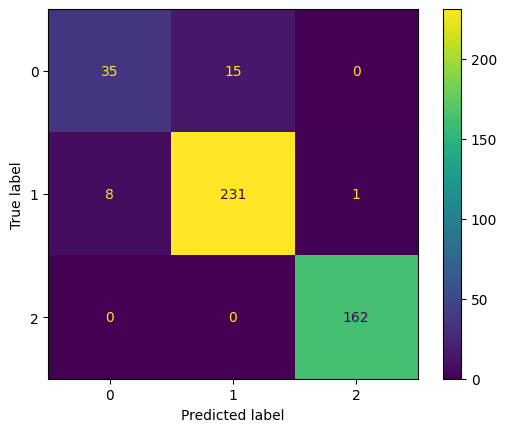

In [17]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Report:\n", classification_report(y_test, y_pred_svm))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm)).plot()

# 🤖 Build & Train CNN Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 734ms/step - accuracy: 0.7075 - loss: 0.7559 - val_accuracy: 0.9358 - val_loss: 0.1858
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 707ms/step - accuracy: 0.9793 - loss: 0.0898 - val_accuracy: 0.9823 - val_loss: 0.0852
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.9934 - loss: 0.0313 - val_accuracy: 0.9735 - val_loss: 0.0783
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 696ms/step - accuracy: 0.9962 - loss: 0.0173 - val_accuracy: 0.9823 - val_loss: 0.0663
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 667ms/step - accuracy: 0.9908 - loss: 0.0192 - val_accuracy: 0.9845 - val_loss: 0.0620
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95        50
           1       1.00      0.98      0.99       240
           2       0.98      1.00      0.99       162

    accuracy                           0.98       452
   macro avg       0

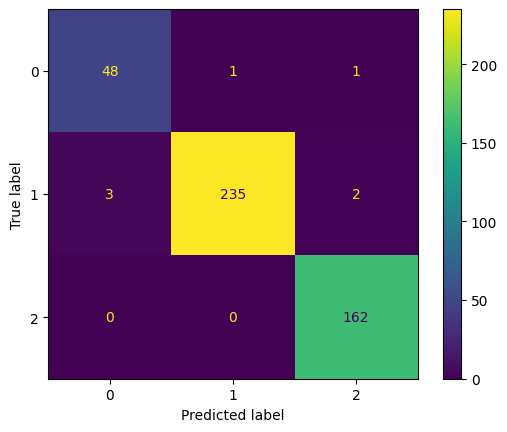

In [18]:
# Prepare data
X_dl = X.toarray()
X_dl = X_dl.reshape((X_dl.shape[0], X_dl.shape[1], 1))
y_cat = to_categorical(y, num_classes=3)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_cat, test_size=0.2, random_state=42)

# Build CNN
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_dl.shape[1], 1)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_dl, y_train_dl, epochs=5, validation_data=(X_test_dl, y_test_dl)) #Chnage to 15 or 20 for higher accuracy

# Evaluate
y_test_dl_labels = np.argmax(y_test_dl, axis=1)
y_pred_cnn_probs = model.predict(X_test_dl)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

print("CNN Classification Report:\n", classification_report(y_test_dl_labels, y_pred_cnn))
ConfusionMatrixDisplay(confusion_matrix(y_test_dl_labels, y_pred_cnn)).plot()

# 💾 Save Trained Models and Vectorizer

In [19]:
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
model.save("cnn_email_classifier.h5")

# 📈 Real-Time Model Performance Comparison (RF, SVM, CNN)


In [20]:
# For ML models (RF & SVM)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
svm_f1 = f1_score(y_test, y_pred_svm, average='macro')

# For CNN
cnn_accuracy = accuracy_score(y_test_dl_labels, y_pred_cnn)
cnn_f1 = f1_score(y_test_dl_labels, y_pred_cnn, average='macro')

In [21]:
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'CNN (Deep Learning)'],
    'Accuracy': [rf_accuracy, svm_accuracy, cnn_accuracy],
    'F1-Score (Macro Avg)': [rf_f1, svm_f1, cnn_f1]
})

results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x*100:.2f}%")
results_df['F1-Score (Macro Avg)'] = results_df['F1-Score (Macro Avg)'].apply(lambda x: f"{x*100:.2f}%")

print(results_df)

                 Model Accuracy F1-Score (Macro Avg)
0        Random Forest   95.58%               91.60%
1                  SVM   94.69%               90.01%
2  CNN (Deep Learning)   98.45%               97.62%


# 📉 Visual Comparison of Model Performance (Bar Chart)

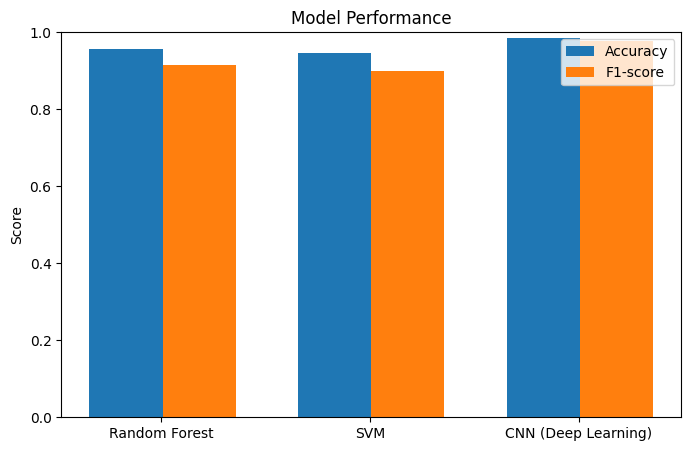

In [22]:
# For live bar chart
models = results_df['Model']
acc_vals = [rf_accuracy, svm_accuracy, cnn_accuracy]
f1_vals = [rf_f1, svm_f1, cnn_f1]

x = range(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x, acc_vals, width=0.35, label='Accuracy')
plt.bar([i + 0.35 for i in x], f1_vals, width=0.35, label='F1-score')
plt.xticks([i + 0.17 for i in x], models)
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Model Performance")
plt.legend()
plt.show()

# 📦 Install Streamlit and Pyngrok

In [23]:
!pip install streamlit pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


# 🧹 Resetting ngrok Configuration

In [24]:
!rm -rf ~/.ngrok2

# 🔑 ngrok Authentication Setup

In [25]:
!ngrok config add-authtoken "2vgtbiaXLHJfQuVZxZN1qTOBh8w_2TKKgc3JRy9f3gUrFY1i8"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


# 🚀 Launch Streamlit via Ngrok


In [26]:
from pyngrok import ngrok

!streamlit run "/content/drive/MyDrive/DL/lib/app.py" &>/content/logs.txt &

public_url = ngrok.connect(8501)
print("🔗 Your website is live at:", public_url.public_url)

🔗 Your website is live at: https://56e5-34-141-241-181.ngrok-free.app
